<a href="https://colab.research.google.com/github/Rohanrathod7/my-ml-labs/blob/main/20_Introduction_to_Deep_Learning_with_PyTorch/03_Training_a_Neural_Network_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 3. Training a Neural Network with PyTorch


learn how to compute tf-idf weights and the cosine similarity score between two vectors. You will use these concepts to build a movie and a TED Talk recommender. Finally, you will also learn about word embeddings and using word vector representations, you will compute similarities between various Pink Floyd songs.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime as dt
# Import confusion matrix and train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LogisticRegression, LinearRegression
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier

url = "https://raw.githubusercontent.com/Rohanrathod7/my-ml-labs/main/19_Feature_Engineering_for_NLP_in_Python/Dataset/ted.csv"
# Read the CSV file
# Apply pd.to_numeric only to relevant columns, excluding 'text'
ted = pd.read_csv(url)


display(ted.head())

,transcript,url
0,"We're going to talk — my — a new lecture, just...",https://www.ted.com/talks/al_seckel_says_our_b...
1,"This is a representation of your brain, and yo...",https://www.ted.com/talks/aaron_o_connell_maki...
2,It's a great honor today to share with you The...,https://www.ted.com/talks/carter_emmart_demos_...
3,"My passions are music, technology and making t...",https://www.ted.com/talks/jared_ficklin_new_wa...
4,It used to be that if you wanted to get a comp...,https://www.ted.com/talks/jeremy_howard_the_wo...


**Using TensorDataset**  
Structuring your data into a dataset is one of the first steps in training a PyTorch neural network. TensorDataset simplifies this by converting NumPy arrays into a format PyTorch can use.

In this exercise, you'll create a TensorDataset using the preloaded animals dataset and inspect its structure.

In [13]:
import torch
from torch.utils.data import TensorDataset
import pandas as pd

# Define the data as a dictionary
data = {
    'animal_name': ['sparrow', 'eagle', 'cat', 'dog', 'lizard'],
    'hair': [0, 0, 1, 1, 0],
    'feathers': [1, 1, 0, 0, 0],
    'eggs': [1, 1, 0, 0, 1],
    'milk': [0, 0, 1, 1, 0],
    'predator': [0, 1, 1, 0, 1],
    'legs': [2, 2, 4, 4, 4],
    'tail': [1, 1, 1, 1, 1],
    'type': [0, 0, 1, 1, 2]
}

# Create a pandas DataFrame
animals = pd.DataFrame(data)

# Extract features (X) and labels (y)
X = animals.iloc[:, 1:-1].to_numpy()
y = animals.iloc[:, -1].to_numpy()

# Create a TensorDataset
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))

# Print the first sample
input_sample, label_sample = dataset[0]
print('Input sample:', input_sample)
print('Label sample:', label_sample)

# You’ve successfully converted our animals dataset into a PyTorch-friendly format.

Input sample: tensor([0., 1., 1., 0., 0., 2., 1.])
Label sample: tensor(0)


**Using DataLoader**  
The DataLoader class is essential for efficiently handling large datasets. It speeds up training, optimizes memory usage, and stabilizes gradient updates, making deep learning models more effective.

Now, you'll create a PyTorch DataLoader using the dataset from the previous exercise and see it in action.

In [14]:

from torch.utils.data import DataLoader

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Iterate over the dataloader
for batch_inputs, batch_labels in dataloader:
    print('batch_inputs:', batch_inputs)
    print('batch_labels:', batch_labels)

# You’ve set up a DataLoader to efficiently process data in batches.

batch_inputs: tensor([[0., 0., 1., 0., 1., 4., 1.],
        [1., 0., 0., 1., 1., 4., 1.]])
batch_labels: tensor([2, 1])
batch_inputs: tensor([[0., 1., 1., 0., 0., 2., 1.],
        [1., 0., 0., 1., 0., 4., 1.]])
batch_labels: tensor([0, 1])
batch_inputs: tensor([[0., 1., 1., 0., 1., 2., 1.]])
batch_labels: tensor([0])


### Writing our first training loop

**Using the MSELoss**  
For regression problems, you often use Mean Squared Error (MSE) as a loss function instead of cross-entropy. MSE calculates the squared difference between predicted values (y_pred) and actual values (y). Now, you'll compute MSE loss using both NumPy and PyTorch.

torch, numpy (as np), and torch.nn (as nn) packages are already imported.

In [15]:
import numpy as np
import torch.nn as nn
import torch

y_pred = np.array([3, 5.0, 2.5, 7.0])
y = np.array([3.0, 4.5, 2.0, 8.0])

# Calculate MSE using NumPy
mse_numpy = np.mean((y_pred - y)**2)

# Create the MSELoss function in PyTorch
criterion = nn.MSELoss()

# Calculate MSE using PyTorch
mse_pytorch = criterion(torch.tensor(y_pred), torch.tensor(y))

print("MSE (NumPy):", mse_numpy)
print("MSE (PyTorch):", mse_pytorch)

# The loss outputs for both NumPy and PyTorch match perfectly

MSE (NumPy): 0.375
MSE (PyTorch): tensor(0.3750, dtype=torch.float64)


**Writing a training loop**  
In scikit-learn, the training loop is wrapped in the .fit() method, while in PyTorch, it's set up manually. While this adds flexibility, it requires a custom implementation.

In this exercise, you'll create a loop to train a model for salary prediction.

The show_results() function is provided to help you visualize some sample predictions.

The package imports provided are: pandas as pd, torch, torch.nn as nn, torch.optim as optim, as well as DataLoader and TensorDataset from torch.utils.data.

The following variables have been created: num_epochs, containing the number of epochs (set to 5); dataloader, containing the dataloader; model, containing the neural network; criterion, containing the loss function, nn.MSELoss(); optimizer, containing the SGD optimizer.

In [24]:
# Define the number of epochs
num_epochs = 5

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple placeholder model (replace with your actual model)
# Assuming X and y are defined from your data in a previous cell
input_size = X.shape[1] # Number of features
output_size = len(torch.unique(torch.tensor(y))) # Number of unique classes

model = nn.Linear(input_size, output_size)

# Define a placeholder criterion (replace with your actual loss function)
criterion = nn.CrossEntropyLoss() # Example for classification

# Define a placeholder optimizer (replace with your actual optimizer)
optimizer = optim.SGD(model.parameters(), lr=0.01) # Example with SGD

# Loop over the number of epochs and the dataloader
for epoch in range(num_epochs):
  for data in dataloader:
    # Set the gradients to zero
    optimizer.zero_grad()
    # Run a forward pass
    feature, target = data
    prediction = model(feature)
    # Compute the loss
    loss = criterion(prediction, target)
    # Compute the gradients
    loss.backward()
    # Update the model's parameters
    optimizer.step()

# Calculate and print accuracy after training
model.eval() # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad(): # Disable gradient calculation
    for data in dataloader:
        feature, target = data
        outputs = model(feature)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'Accuracy of the model on the training data: {100 * correct / total}%')

# building your first PyTorch training loop! Next, we’ll dive into activation functions and hyperparameters—essential steps for creating smarter, more efficient models.

Accuracy of the model on the training data: 40.0%


### ReLU activation functions


**Implementing ReLU**  
The Rectified Linear Unit (ReLU) is a widely-used activation function in deep learning, solving challenges like the vanishing gradients problem.

In this exercise, you'll implement ReLU in PyTorch, apply it to both positive and negative values, and observe the results.

torch.nn package has already been imported for you as nn.

In [25]:
# Create a ReLU function with PyTorch
relu_pytorch = nn.ReLU()

x_pos = torch.tensor(2.0)
x_neg = torch.tensor(-3.0)

# Apply the ReLU function to the tensors
output_pos = relu_pytorch(x_pos)
output_neg = relu_pytorch(x_neg)

print("ReLU applied to positive value:", output_pos)
print("ReLU applied to negative value:", output_neg)

# ReLU is now working perfectly! Positive inputs keep their value, while negative ones turn to 0

ReLU applied to positive value: tensor(2.)
ReLU applied to negative value: tensor(0.)


**Implementing leaky ReLU**  
While ReLU is widely used, it sets negative inputs to 0, resulting in null gradients for those values. This can prevent parts of the model from learning.

Leaky ReLU overcomes this by allowing small gradients for negative inputs, controlled by the negative_slope parameter. Instead of 0, negative inputs are scaled by this small value, keeping the model's learning active.

In this exercise, you will implement the leaky ReLU function in PyTorch and practice using it. torch package as well as the torch.nn as nn have already been imported.

In [26]:
# Create a leaky relu function in PyTorch
leaky_relu_pytorch = nn.LeakyReLU(negative_slope=0.05)

x = torch.tensor(-2.0)
# Call the above function on the tensor x
output = leaky_relu_pytorch(x)
print(output)

tensor(-0.1000)


**Question**  
For a negative slope of 0.05 and an input value of -3, what is the output of the leaky ReLU function?

    -> -0.15

    Leaky ReLU is another very popular activation function found in modern architecture. By never setting the gradients to zero, it allows every parameter of the model to keep learning.

***Understanding activation functions***  
You've learned all about ReLU vs. leaky ReLU. Which two of the following statements are True?

    -> The ReLU activation function outputs zero for negative inputs.
    [ For positive inputs, the ReLU function returns the input itself. ]


    Sigmoid activation functions are often found after each linear layer in a network.
    [ The difference between ReLU and leaky ReLU concerns negative inputs. ]
    

    -> ReLU(x) = 3 for x = 3.
    [ The difference between ReLU and leaky ReLU concerns negative inputs. ]


    Leaky ReLU outputs the same constant value for negative inputs.

*A good rule of thumb is to use ReLU as the default activation function in your models (except for the last layer).*

### Learning rate and momentum

**Experimenting with learning rate**  
In this exercise, your goal is to find the optimal learning rate such that the optimizer can find the minimum of the non-convex function
 in ten steps.

You will experiment with three different learning rate values. For this problem, try learning rate values between 0.001 to 0.1.

You are provided with the optimize_and_plot() function that takes the learning rate for the first argument. This function will run 10 steps of the SGD optimizer and display the results.

In [46]:
def optimize_and_plot(lr=0.01, momentum=0.0):
  x = torch.tensor(2.0, requires_grad=True)
  buffer = torch.zeros_like(x.data)
  values = []
  for i in range(10):

      y = function(x)
      values.append((x.clone(), y.clone()))
      y.backward()

      d_p = x.grad.data
      if momentum !=0 :
          buffer.mul_(momentum).add_(d_p)
          d_p = buffer

      x.data.add_(d_p, alpha=-lr)
      x.grad.zero_()

  x = np.arange(-3, 2, 0.001)
  y = function(x)

  plt.figure(figsize=(10, 5))
  plt.plot([v[0].detach().numpy() for v in values], [v[1].detach().numpy() for v in values], 'r-X',
           linewidth=2, markersize=7)
  for i in range(10):
      plt.text(values[i][0].detach().numpy()+0.1, values[i][1].detach().numpy(), f'step {i}', fontdict={'color': 'r'})
  plt.plot(x, y, linewidth=2)
  plt.grid()
  plt.tick_params(axis='both', which='major', labelsize=12)
  plt.legend(['Optimizer steps', 'Square function'])
  plt.show()

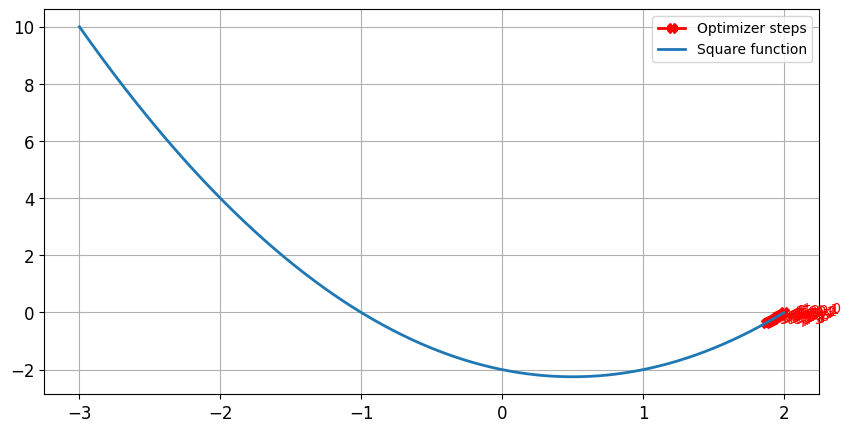

In [48]:
# Try a first learning rate value
lr0 = 0.005
optimize_and_plot(lr=lr0)

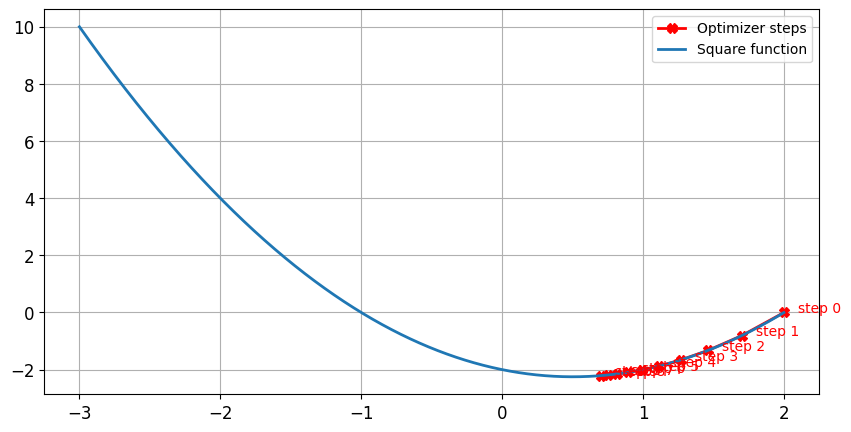

In [50]:
# Try a second learning rate value
lr1 = 0.1
optimize_and_plot(lr=lr1)

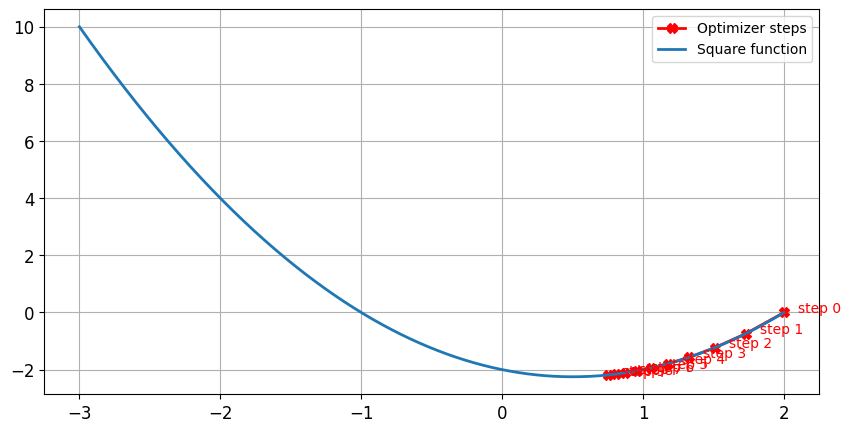

In [49]:


# Try a third learning rate value
lr2 = 0.09
optimize_and_plot(lr=lr2)

#  A learning rate around 0.09 gets you closest to the global minimum.

**Experimenting with momentum**

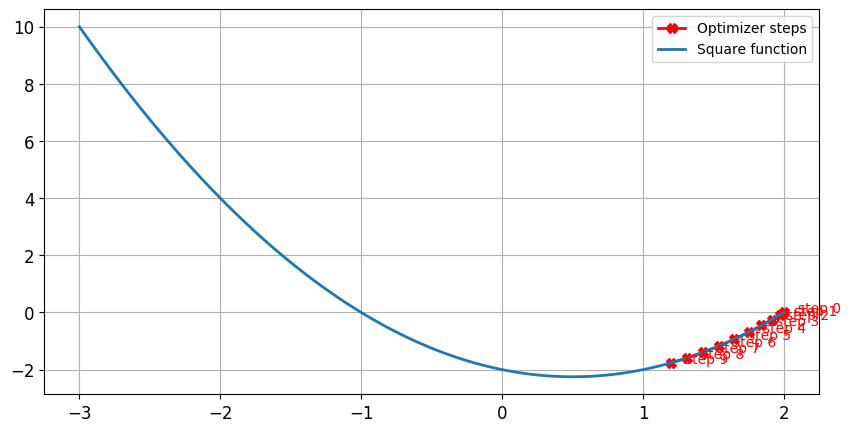

In [52]:
# Try a first value for momentum
mom0 = 0.85
optimize_and_plot(momentum=mom0)

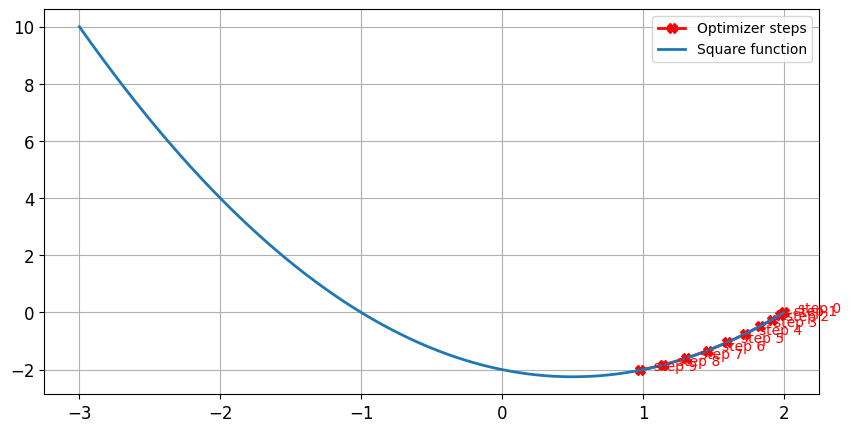

In [53]:
# Try a second value for momentum
mom1 = 0.95
optimize_and_plot(momentum=mom1)

# Momentum and learning rate are critical to the training of your neural network.
# A good rule of thumb is to start with a learning rate of 0.001 and a momentum of 0.95.